$$
\newcommand{\parens}[1]{\mathopen{}\left(#1\right)\mathclose{}}
\newcommand{\bracks}[1]{\mathopen{}\left[#1\right]\mathclose{}}
\newcommand{\braces}[1]{\mathopen{}\left\{#1\right\}\mathclose{}}
\newcommand{\abs}[1]{\mathopen{}\left\lvert#1\right\rvert\mathclose{}}
\newcommand{\norm}[1]{\mathopen{}\left\lVert#1\right\rVert\mathclose{}}
\renewcommand{\vec}[1]{\boldsymbol{\mathbf{#1}}}
\newcommand{\mat}[1]{\mathbf{#1}}
\newcommand{\tpose}[1]{#1^T}
\newcommand{\inv}[1]{#1^{-1}}
\newcommand{\Matrix}[1]{
  \begin{bmatrix}
    #1
  \end{bmatrix}
}
\newcommand{\seq}[1]{1, 2, \ldots, #1}
\newcommand{\reals}{\mathbb{R}}
\newcommand{\mper}{\,\text{.}}
\newcommand{\mcom}{\,\text{,}}
$$

(churn)=
# Predicting Churn with Amazon SageMaker

## Summary

I prototyped a model to predict the probability a customer churns using scikit-learn.
I then identified which characteristics were important and used those insights to suggest personalized customer retention strategies in an automated way.
Finally, I trained and deployed the model to a hosted endpoint with Amazon SageMaker that is capable of making real-time predictions and automatically suggesting personalized retention strategies.

```{note}
You can run and modify the training and inference code on this page Jupyter Notebook style, but without leaving the page!
Hover over the {fa}`rocket` launch button at the top of the page, then click the {guilabel}`Live Code` button.
Once you see "Launching from mybinder.org: ready", you can run code cells.
Refresh the page to revert to the original view.
```

## Introduction

It is important for any business to retain their customers.
Therefore it is important to predict ahead of time who is at risk to churn and implement cost effective strategies to retain them.
My model and its associated retention strategies are specific to a company that offers phone and internet services, but the approach is generalizable to other domains and datasets.

### Data Source

I used the Telco customer churn dataset available by IBM [here](https://github.com/IBM/telco-customer-churn-on-icp4d).
It consists of data about a fictional company that provides phone and internet service to approximately 7,000 customers.
Each customer has 20 variables including whether or not they churned this quarter, the services they use, how much they pay, how long they've been a customer, and basic demographic information.

### Model Choice

I used logistic regression due to its interpretability and thus ability to inform retention strategies.
I also opted for scikit-learn's implementation rather than SageMaker's built-in one for more flexibility;
in particular, it's straightforward to access the model's coefficients via a scikit-learn training script to make personalized recommendations in the deployed model.
Though I do not show it here, prediction focused algorithms like support vector machines or gradient boosted trees only have marginally better accuracy than cross-validated, regularized logistic regression.
Combining with logistic regression's interpretability makes it a strong choice here.

(churn-train)=
## Model Training

Before training a classification model with scikit-learn, we must split the data into a matrix of predictors `X` and a vector of responses `y` indicating the true labels.
Because many variables in the churn dataset are categorical variables like yes/no, we also need to specially encode them.
For binary variables, a simple numeric 0/1 coding is sufficient.
For categorical variables with $k$ categories, creating $k - 1$ binary (dummy) variables is the most flexible way to model them.
Finally, we should split the data into a training/test set to assess the performance of our trained model.

In [1]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Split data into X (predictors) and y (response). Also fill in missing
# values and ensure categorical predictors are treated consistently.
df = pd.read_csv('churn.csv')
X = df.drop(['customerID', 'Churn'], axis=1)
X['SeniorCitizen'] = np.where(X['SeniorCitizen'] == 1, 'yes', 'no')
X['TotalCharges'] = np.where(X['tenure'] == 0, 0, X['TotalCharges'])
y = df['Churn']

# Create k-1 dummy variables for k-category predictors, ensure numeric
# variables are numbers, and encode the binary response to numeric
# 0 (yes churn) and 1 (yes churn).
numeric_vars = ['tenure', 'MonthlyCharges', 'TotalCharges']
categorical_vars = [var for var in X.columns if var not in numeric_vars]
X[numeric_vars] = X[numeric_vars].apply(pd.to_numeric)
X = pd.get_dummies(X, columns=categorical_vars, drop_first=True)
y = pd.factorize(y)[0]

# Split into training and test sets.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1)

For logistic regression, the main tuning parameter is the type and amount of regularization on the model coefficients.
$l_2$ (ridge) regularization generally results in better predictions but $l_1$ (LASSO) regularization is able to perform variable selection.
In this case, the interpretability increase of the $l_1$ model is only minimal, so I'll stick with $l_2$, optimizing the amount of regularization with cross-validation:

Optimal amount of regularization: [0.04641589]


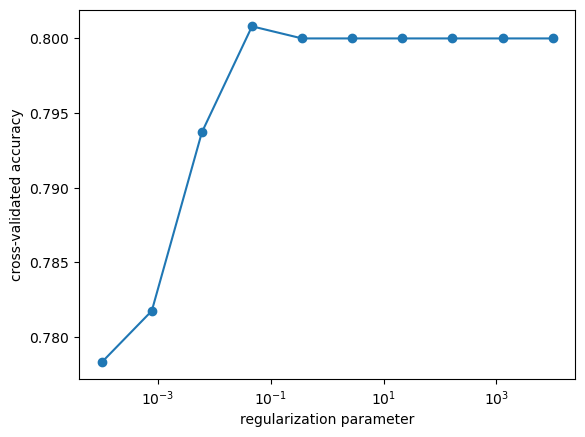

In [2]:

from sklearn.linear_model import LogisticRegressionCV
import matplotlib.pyplot as plt

model = LogisticRegressionCV(cv=5, penalty='l2', max_iter=1000,
                             random_state=1)
model.fit(X_train, y_train)

fig, ax = plt.subplots()
ax.plot(model.Cs_, np.mean(model.scores_[1], axis=0), '-o')
ax.set(ylabel='cross-validated accuracy', xlabel='regularization parameter',
       xscale='log')
print(f'Optimal amount of regularization: {model.C_}')

Examining accuracies on the training and test sets:

In [3]:

print(f'Accuracy on training set: {model.score(X_train, y_train)}')
print(f'Accuracy on test set: {model.score(X_test, y_test)}')

Accuracy on training set: 0.8046653144016227
Accuracy on test set: 0.8116422148603881


we see that the model generalized well.
Though we only trained on 70% of the data, when we deploy the model we should use all of the data.
The above test suggests it's reasonable to use $l_2$ regularization with amount near `C=.05`.


## Model Inference

Before deploying the model for use in production, we should learn about it to inform business decisions based on the model predictions.
For example, while it's useful to identify customers expected to churn, it's even more useful to identify why they're expected to churn and develop customer retention strategies.
Let's first train the model on all of the data:

In [4]:

from sklearn.linear_model import LogisticRegression

model = LogisticRegression(C=.05, penalty='l2', max_iter=1000, random_state=1)
model.fit(X, y)
model.score(X, y)

0.8059065739031662

### Complementary Metrics to Accuracy

While accuracy is a useful metric, it's not always the best one, particularly for imbalanced data.
For instance, if our model always predicted no churn:

In [5]:

print(f'Accuracy when predicting no one churns: {np.mean(y == 0)}')

Accuracy when predicting no one churns: 0.7346301292063041


it still achieves 73% accuracy.
However, it identifies no customer that churns, and is ultimately useless to the business.
A more complete picture examines false positives and negatives in the *confusion matrix*:

In [6]:

from sklearn.metrics import confusion_matrix

y_true = y
y_pred = model.predict(X)
pd.DataFrame(confusion_matrix(y_true, y_pred),
             columns=['pred 0', 'pred 1'], index=['true 0', 'true 1'])

,pred 0,pred 1
true 0,4655,519
true 1,848,1021


For instance, two questions of interest are: (1) among all customers who churned, how many did we correctly predict? and (2) among all customers who did not churn, how many did we correct predict?
These are the true positive and true negative rates, respectively.
In this case, they are:

In [7]:

print('True positive rate:', 1021 / (848 + 1021))
print('True negative rate:', 4655 / (4655 + 519))

True positive rate: 0.5462814339218833
True negative rate: 0.8996907614998068


These metrics can be tuned by the prediction threshold, which currently predicts a customer churns if their probability of churning is $p_\ast = 0.5$ or more.
The threshold depends on the cost of customer churn and customer retention strategies, both to the business and the customer.
If the strategy is expensive to implement, a higher probability threshold should be used.
If the cost of churn is more expensive, a lower probability threshold should be used.
Different thresholds can also be used for different customer retention strategies.
For example, a threshold of $p_\ast = 0.3$ results in true positive and negative rates near 76\%.
The improved identification of customers who are likely to churn may offset the reduction in overall accuracy, down to 77%.
Clearly there is a tradeoff between true positive and negative rates, but the ability to tune the threshold to the business' needs is a strength of the logistic regression model.
A detailed analysis to choose $p_\ast$ in conjunction with retention strategies is warranted, with input from experts in finance, customer experience, marketing, etc.

### Informing Retention Strategies

Another important question is "what predictors are related to customer churn?"
These can help inform what retention strategies should be used.
We can answer this by looking at the effects of changing predictor values, which are closely related to the logistic regression coefficients:

In [8]:

effects = pd.Series(model.coef_[0].copy(), index=X.columns)
effects[numeric_vars] *= X[numeric_vars].apply(np.std) / 2
effects.head()

tenure              -0.772033
MonthlyCharges       0.101111
TotalCharges         0.365056
gender_Male         -0.036198
SeniorCitizen_yes    0.211798
dtype: float64

For numeric variables, I specified the effect of an increase of half a standard deviation, which are approximately 1 year as a customer (`tenure`), \$15/month (`MonthlyCharges`), and \$1,000 total (`TotalCharges`).
Effects that are large in magnitude and positive are associated with an increase in probability to churn.
On the other hand, effects that are large in magnitude but negative are associated with a decrease in probability to churn.
Effects close to zero have little impact.
Looking at their distribution,

[Text(0.5, 0, 'Typical predictor effects')]

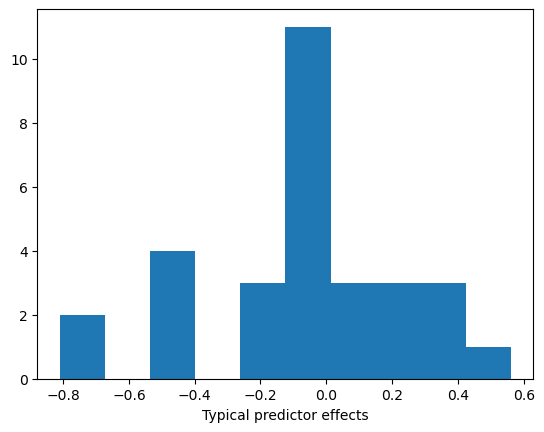

In [9]:

fig, ax = plt.subplots()
ax.hist(effects, bins=10)
ax.set(xlabel='Typical predictor effects')

we can define the most impactful effects to have magnitude larger than 0.3.

In [10]:

effects[np.abs(effects) > .3].sort_values()

Contract_Two year             -0.809298
tenure                        -0.772033
Contract_One year             -0.476092
TechSupport_Yes               -0.439334
PhoneService_Yes              -0.433702
OnlineSecurity_Yes            -0.425426
PaperlessBilling_Yes           0.315337
TotalCharges                   0.365056
InternetService_Fiber optic    0.561126
dtype: float64

Evidently having a contract is one of the most impactful predictors of churn.
About half of those in the dataset are on a contract while the other half pay month-to-month.
There is a stark difference comparing churn rates between those groups:

In [11]:

print('Churn rate with a contract', np.mean(y[df.Contract != 'Month-to-month']))
print('Churn rate without a contract', np.mean(y[df.Contract == 'Month-to-month']))

Churn rate with a contract 0.06755050505050506
Churn rate without a contract 0.4270967741935484


Customers who've had a longer tenure with the company are also less likely to churn.
This combination suggests that offering contracts may be an effective customer retention strategy.
Add-on services like tech support and online security also reduce churn rate.

There are a few indications that internet users are more likely to churn.
This is probably due to the fact that phone service is more portable, and not a reason the company should stop offering internet services.
While total charge history is associated with more customer churn, this effect is not relevant because we don't have what-if scenarios like "what if this customer suddenly spent another $1,000?"
In addition, a larger total charge amount is generally cancelled out by longer tenures due to the correlation of those variables.
Monthly payments are more relevant and modifiable, but do not show up in the top effects.

There are a few less clear indicators like paperless billing.
This does not mean that enrolling in paperless billing causes a customer to churn, i.e. advising customers to not enroll in paperless billing is not an effective retention solution.
More likely there is an unmeasured variable like age that is correlated with paperless billing and churn, e.g. younger people are more likely to enroll in paperless billing and move (resulting in churn).

(churn-personalize)=
### Personalizing Retention Strategies

The previous discussion is about average effects over the entire population, but are not personalized.
It would be better if we could answer "what should we do for this specific person to retain them as a customer?"
To do that, we can look at the model coefficients weighted by the actual predictor values of a person.
This tells us each predictor's contribution to the churn probability for a particular customer.
For instance, consider the following person who's predicted to churn with 78% probability:

In [12]:

x = X.loc[[346]]
model.predict_proba(x)

array([[0.22470234, 0.77529766]])

We can compute their personalized effects as follows:

In [13]:

def get_personalized_effects(model, x, nonzero=True):
    """Extract components of the linear predictor in the logistic regression
    model for a customer with predictor values `x`."""
    personalized_effects = x * model.coef_
    personalized_effects = personalized_effects.squeeze().sort_values()
    if nonzero:
        return personalized_effects[personalized_effects != 0]
    else:
        return personalized_effects

get_personalized_effects(model, x)

PhoneService_Yes                 -0.433702
tenure                           -0.125750
TotalCharges                      0.054179
StreamingTV_Yes                   0.100488
StreamingMovies_Yes               0.112199
PaymentMethod_Electronic check    0.288616
PaperlessBilling_Yes              0.315337
InternetService_Fiber optic       0.561126
MonthlyCharges                    0.607583
Name: 346, dtype: float64

The only personalized effects lowering their predicted churn probability are phone service and a relatively short tenure.
On the other hand, they have high monthly charges, are an internet user, and are enrolled in paperless billing and pay electronically.
Of those, only their monthly rate is actionable, so one solution would be to offer a contract at a slightly lower monthly rate.
A better solution would use what we learned about the population of customers overall and also offer a contract.
If they commited to a 2-year contract at 90% of their current rate, their predicted churn probability would decrease to 58%:

In [14]:

x_modified = x.copy()
x_modified['Contract_Two year'] = 1
x_modified['MonthlyCharges'] *= .9
x_modified['tenure'] += 1
x_modified['TotalCharges'] += x_modified['MonthlyCharges']
model.predict_proba(x_modified)

array([[0.41781569, 0.58218431]])

Further adding tech support and online security to their contract lowers their churn probability to 37%:

In [15]:

x_modified['TechSupport_Yes'] = 1
x_modified['OnlineSecurity_Yes'] = 1
model.predict_proba(x_modified)

array([[0.63018573, 0.36981427]])

The above reasoning can be automated in the following `suggest_retention_measures()` function, which returns a list of recommended retention measures.

In [16]:

def suggest_retention_measures(model, x):
    """Given the logistic regression customer churn model and predictor values
    `x` of a particular customer, create a list of possible customer
    retention measures in order of greatest predicted effect."""
    measures = []
    personalized_effects = get_personalized_effects(model, x, nonzero=False)

    has_no_contract = (x['Contract_Two year'].values[0] == 0
                       and x['Contract_One year'].values[0] == 0)
    if has_no_contract and personalized_effects.idxmax() == 'MonthlyCharges':
        measures.append(
            'Offer customer a promotional contract and consider lowering '
            'their monthly rate (${}).'.format(x['MonthlyCharges'].values[0])
        )
    elif has_no_contract:
        measures.append(
            'Offer customer a promotional contract at a similar monthly '
            'rate (${}).'.format(x['MonthlyCharges'].values[0])
        )
    if x['TechSupport_Yes'].values[0] == 0:
        measures.append('Offer customer tech support.')
    if x['PhoneService_Yes'].values[0] == 0:
        measures.append('Offer customer phone service.')
    if x['OnlineSecurity_Yes'].values[0] == 0:
        measures.append('Offer customer online security.')
    if not measures:
        print('No automated solution suggested.'
              "Returning customer's personalized effects to analyze.")
        return personalized_effects
    else:
        return measures

suggest_retention_measures(model, x)

['Offer customer a promotional contract and consider lowering their monthly rate ($90.4).',
 'Offer customer tech support.',
 'Offer customer online security.']

## Model Deployment

Using the previous training and inference code as a foundation, we are now ready to deploy the model with Amazon SageMaker.

### Python Training Script

The first step is to include a Python training script that SageMaker will import during the training step.
The training code is nearly identical to the code in § [](churn-train), but because SageMaker calls this script via command line, we must parse arguments like hyperparameter values and file directory locations.
We also need a way to serialize and deserialize the trained model, done with the `joblib` module and a custom `model_fn()` function, so SageMaker understands them.
Finally, I modified the inference code in `predict_fn()` to return the predicted probability and model coefficients for making personalized retention strategies, rather than just a yes/no customer churn prediction.
The following is my complete `sklearn_churn.py` training script:

```python
import argparse
import os
import joblib
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression


if __name__ == '__main__':
    parser = argparse.ArgumentParser()

    # Define hyperparameters
    parser.add_argument('--regularization', type=float, default=1)

    # Sagemaker specific arguments. Defaults are set in the environment variables.
    parser.add_argument('--output-data-dir', type=str, default=os.environ['SM_OUTPUT_DATA_DIR'])
    parser.add_argument('--model-dir', type=str, default=os.environ['SM_MODEL_DIR'])
    parser.add_argument('--train', type=str, default=os.environ['SM_CHANNEL_TRAIN'])

    args = parser.parse_args()

    # Load in data and split into X and y
    df = pd.read_csv(os.path.join(args.train, 'train.csv'))
    X = df.drop(['customerID', 'Churn'], axis=1)
    X['SeniorCitizen'] = np.where(X['SeniorCitizen'] == 1, 'yes', 'no')
    X['TotalCharges'] = np.where(X['tenure'] == 0, 0, X['TotalCharges'])
    y = df['Churn']

    # Encode categorical variables as dummy variables
    numeric_vars = ['tenure', 'MonthlyCharges', 'TotalCharges']
    categorical_vars = [var for var in X.columns if var not in numeric_vars]
    X[numeric_vars] = X[numeric_vars].apply(pd.to_numeric)
    X = pd.get_dummies(X, columns=categorical_vars, drop_first=True)
    y = pd.factorize(y)[0]

    # Fit model
    C = args.regularization
    model = LogisticRegression(C=C, penalty='l2', max_iter=10000, random_state=1)
    model.fit(X, y)

    # Save model to `model_dir` as file 'model.joblib'
    joblib.dump(model, os.path.join(args.model_dir, 'model.joblib'))


def model_fn(model_dir):
    """Deserialize and return fitted model."""
    model = joblib.load(os.path.join(model_dir, "model.joblib"))
    return model


def predict_fn(x, model):
    churn_prob = model.predict_proba(x)[0][1]
    coef = model.coef_[0]
    return np.array([churn_prob, coef], dtype='object')
```

### SageMaker Notebook Instance

Next, we can write the training and inference code in a Jupyter Notebook using a SageMaker notebook instance.
Once the Jupyter environment is created, upload the above training script `sklearn_churn.py`.
The following code cells and output were run in the SageMaker notebook using a file titled `telco-churn.ipynb`.
First, download the data and save it to the `data` folder in the current working directory:

```python
# Download and save data

import os
import urllib.request

os.makedirs('./data', exist_ok=True)

data_url = 'https://raw.githubusercontent.com/IBM/telco-customer-churn-on-icp4d/master/data/Telco-Customer-Churn.csv'
try:
    urllib.request.urlretrieve(data_url, filename='data/train.csv')
    print('Success: downloaded Telco customer churn data to data/train.csv.')
except Exception as e:
    print('Data load error: ',e)
```

    Success: downloaded Telco customer churn data to data/train.csv.


```bash
# Check contents of working directory

! ls --recursive
```

    .:
    data  lost+found  sklearn_churn.py  telco-churn.ipynb

    ./data:
    train.csv
    ls: cannot open directory ./lost+found: Permission denied

Next, upload the data to a default Amazon S3 bucket using the SageMaker Python SDK, and create a role to enable permissions:

```python
# Upload data to S3

import sagemaker

prefix = 'sklearn-telco-churn'
work_directory = 'data'
sagemaker_session = sagemaker.Session()

train_input = sagemaker_session.upload_data(
    work_directory, key_prefix=f'{prefix}/{work_directory}'
)
```

```python
# Get a SageMaker-compatible role used by this notebook instance

from sagemaker import get_execution_role

role = get_execution_role()
```

We are now ready to create and train the model.
We do this by creating a scikit-learn estimator, which uses our training script `sklearn_churn.py`, and calling its `fit()` method:

```python
# Create sklearn estimator and train the model

from sagemaker.sklearn.estimator import SKLearn

framework_version = "0.23-1"
script_path = "sklearn_churn.py"

model = SKLearn(
    entry_point = script_path,
    framework_version = framework_version,
    instance_type = 'ml.m4.xlarge',
    role = role,
    sagemaker_session = sagemaker_session,
    hyperparameters = {'regularization': .05},
)

model.fit({'train': train_input})
```

    2021-06-29 19:41:59 Starting - Starting the training job...
    ...(output trimmed)...
    Reporting training SUCCESS

    2021-06-29 19:45:56 Uploading - Uploading generated training model
    2021-06-29 19:45:56 Completed - Training job completed
    Training seconds: 63
    Billable seconds: 63

Finally, deploying the model is just a simple `deploy()` method call:

```python
# Deploy the model

predictor = model.deploy(initial_instance_count=1, instance_type="ml.m4.xlarge")
```

    -----------------!

With the deployed model, we can make real-time predictions using `predictor`.
We can test it within the same Jupyter Notebook by sending requests to the created endpoint.
For simplicity, I'll use the same example in § [](churn-personalize), generating personalized retention strategies for a customer likely to churn.
Let's load in the data and clean it up in a format `predictor` expects:

```python
# Load in data and clean it up

import pandas as pd
import numpy as np

df = pd.read_csv('data/churn.csv')
X = df.drop(['customerID', 'Churn'], axis=1)
X['SeniorCitizen'] = np.where(X['SeniorCitizen'] == 1, 'yes', 'no')
X['TotalCharges'] = np.where(X['tenure'] == 0, 0, X['TotalCharges'])
y = df['Churn']

# Encode categorical variables as dummy variables
numeric_vars = ['tenure', 'MonthlyCharges', 'TotalCharges']
categorical_vars = [var for var in X.columns if var not in numeric_vars]
X[numeric_vars] = X[numeric_vars].apply(pd.to_numeric)
X = pd.get_dummies(X, columns=categorical_vars, drop_first=True)
y = pd.factorize(y)[0]
```

Calling the `predict()` method yields the predicted churn probability and the model coefficients:

```python
x = X.loc[[346]]
predictor.predict(np.array(x))
```

    array([0.7752199488662624,
           array([-6.28816764e-02,  6.71836625e-03,  3.22313109e-04, -3.62093891e-02,
            2.11700027e-01, -1.88526375e-02, -1.72425059e-01, -4.33854036e-01,
            2.64606502e-01,  2.06138086e-01,  5.61257052e-01, -1.00013357e-01,
           -1.00013357e-01, -4.25320987e-01, -1.00013357e-01, -1.80374348e-01,
           -1.00013357e-01, -1.06372626e-01, -1.00013357e-01, -4.39229152e-01,
           -1.00013357e-01,  1.00475922e-01, -1.00013357e-01,  1.12193889e-01,
           -4.76361099e-01, -8.09811673e-01,  3.15258003e-01, -1.27037030e-01,
            2.88597744e-01, -7.67199703e-02])], dtype=object)

Reusing the automatic suggestion of retention measures in § [](churn-personalize), we get the same results as before, but using the deployed model:

```python
def get_personalized_effects(x, coef, nonzero=True):
    """Extract components of the linear predictor in the logistic regression
    model for a customer with predictor values `x`."""
    personalized_effects = x * coef
    personalized_effects = personalized_effects.squeeze().sort_values()
    if nonzero:
        return personalized_effects[personalized_effects != 0]
    else:
        return personalized_effects


def suggest_retention_measures(x, coef):
    """Given the logistic regression customer churn model and predictor values
    `x` of a particular customer, create a list of possible customer
    retention measures in order of greatest predicted effect."""
    measures = []
    personalized_effects = get_personalized_effects(x, coef, nonzero=False)

    has_no_contract = (x['Contract_Two year'].values[0] == 0
                       and x['Contract_One year'].values[0] == 0)
    if has_no_contract and personalized_effects.idxmax() == 'MonthlyCharges':
        measures.append(
            'Offer customer a promotional contract and consider lowering '
            'their monthly rate (${}).'.format(x['MonthlyCharges'].values[0])
        )
    elif has_no_contract:
        measures.append(
            'Offer customer a promotional contract at a similar monthly '
            'rate (${}).'.format(x['MonthlyCharges'].values[0])
        )
    if x['TechSupport_Yes'].values[0] == 0:
        measures.append('Offer customer tech support.')
    if x['PhoneService_Yes'].values[0] == 0:
        measures.append('Offer customer phone service.')
    if x['OnlineSecurity_Yes'].values[0] == 0:
        measures.append('Offer customer online security.')
    if not measures:
        print('No automated solution suggested.'
              "Returning customer's personalized effects to analyze.")
        return personalized_effects
    else:
        return measures

result = predictor.predict(np.array(x))
churn_prob, coef = result[0], result[1]
print(f"Customer {df.customerID[346]}'s churn probability: {churn_prob}")
suggest_retention_measures(x, coef)
```

    Customer 2034-GDRCN's churn probability: 0.7752199488662624

    ['Offer customer a promotional contract and consider lowering their monthly rate ($90.4).',
     'Offer customer tech support.',
     'Offer customer online security.']

Finally, it's good practice to terminate resources when they're not in use, in this case deleting the deployed endpoint:

```python
predictor.delete_endpoint()
```

## Future Work

There are three main avenues of improvement:

1. Determine specific retention strategies after factoring costs of the strategy and of customer churn. Each strategy may have an associated prediction probability threshold $p_\ast$ before it is suggested.
2. Automate the model deployment and inference to periodically predict churn and suggest strategies for all customers, using the most recent data.
3. An improved prediction model. This includes updating the model with the latest data to combat model drift.

As mentioned before, the specific strategies to use should have input from experts in finance, customer experience, marketing, etc. who can help determine their cost and effectiveness.
Given that information, it is much easier to choose $p_\ast$.
A simple model assumes a retention strategy is implemented if the model predicts a customer will churn (which is based on $p_\ast$) at some fixed cost $C_\text{strategy}$.
We also assume a cost if a customer churns, $C_\text{churn}$.
Then assuming customers accept the retention strategy, the total cost to the company as a function of the elements of the confusion matrix (false/true positive/negative) is

$$
C_\text{total} \approx
    C_\text{strategy} \times \text{FP}
    + C_\text{strategy} \times \text{TP}
    + C_\text{churn} \times \text{FN}
    + 0 \times \text{TN}.
$$

Since the elements of the confusion matrix depend on $p_\ast$, we can view this as an optimization problem with cost function $C_\text{total}$ and tunable parameter $p_\ast$.
Of course some true positives can still churn, hence the approximation.
A more detailed model could maximize *expected* profits, factoring in the reduction in churn probability due to a retention strategy.
The probabilities could be informed by the logistic regression model or, even better, by empirical effectiveness in the past.

Regarding the second avenue, it is straightforward to batch train using SageMaker Batch Transform, which just invokes the `tranformer()` method instead of `deploy()` on the scikit-learn estimator `model`.
Automatically retraining, deploying, and batch transforming the data periodically would need to integrate other AWS tools, e.g. Step Functions and AWS Lambda.

Finally, there are multiple ways to improve the model.
I have assumed an *additive* model, meaning that there are no interaction effects between pairs of predictors.
It's possible there are synergistic effects, e.g. customers who have phone and internet service as a bundle may be less likely to churn than expected from their individual effects.
We could also model the numeric variables more flexibly rather than assuming a single linear term, e.g. perhaps there is a critical `tenure` value after which there are diminishing returns.
These modifications would make the model harder to interpret, but gains in predictive accuracy may be worth it.

It could also be useful to collect time data pinpointing when customers churn, and not just whether they did in the past quarter.
Customers who have already churned would still be useful data points in such a *survival analysis* model.
This may be a more efficient use of data and allow us to predict *when* a customer is expected to churn.